In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [5]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Seats are extremely hard an...
1,✅ Trip Verified | Excellent flight. Super cr...
2,✅ Trip Verified | Flight left and arrived on ...
3,Not Verified | My friend and I were helped ...
4,✅ Trip Verified | As a regular flier in this r...


In [7]:
df.to_csv("review.csv")

Congratulations! Now you have your dataset for this task! The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing that you should do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [9]:
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cmaha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\cmaha\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [11]:
# Load data
df = pd.read_csv('review.csv')  # Ensure this file exists

# Clean function
def clean_text(text):
    text = text.lower()                                # Lowercase
    text = re.sub(r'<.*?>', '', text)                  # Remove HTML
    text = re.sub(r'http\S+', '', text)                # Remove URLs
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\d+', '', text)                    # Remove numbers
    words = text.split()
    words = [word for word in words if word not in stopwords.words('english')]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Apply cleaning
df['clean_text'] = df['reviews'].astype(str).apply(clean_text)


In [13]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

df['sentiment_score'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])

def label_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['sentiment_score'].apply(label_sentiment)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\cmaha\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
sentiment_counts = df['sentiment'].value_counts()
print(sentiment_counts)


sentiment
Positive    535
Negative    444
Neutral      21
Name: count, dtype: int64


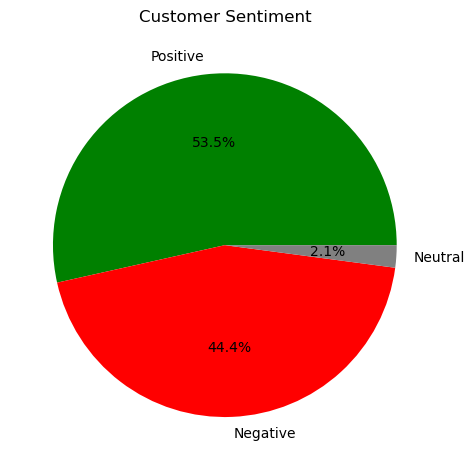

In [19]:
import matplotlib.pyplot as plt

sentiment_counts.plot(kind='pie', autopct='%1.1f%%', colors=['green', 'red', 'grey'], title='Customer Sentiment')
plt.ylabel('')
plt.tight_layout()
plt.show()


In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X = vectorizer.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Print top words per topic
words = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"\nTopic {i+1}: ", [words[i] for i in topic.argsort()[-10:]])



Topic 1:  ['like', 'boarding', 'passenger', 'board', 'crew', 'plane', 'cabin', 'time', 'trip', 'flight']

Topic 2:  ['trip', 'cabin', 'crew', 'service', 'food', 'class', 'business', 'seat', 'flight', 'ba']

Topic 3:  ['airline', 'day', 'airway', 'british', 'service', 'trip', 'customer', 'hour', 'ba', 'flight']

Topic 4:  ['airway', 'economy', 'business', 'service', 'ba', 'good', 'class', 'trip', 'flight', 'seat']

Topic 5:  ['service', 'good', 'staff', 'cabin', 'time', 'ba', 'trip', 'crew', 'seat', 'flight']


In [25]:
pip install wordcloud


  Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl.metadata (3.5 kB)
Using cached wordcloud-1.9.4-cp312-cp312-win_amd64.whl (301 kB)


In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

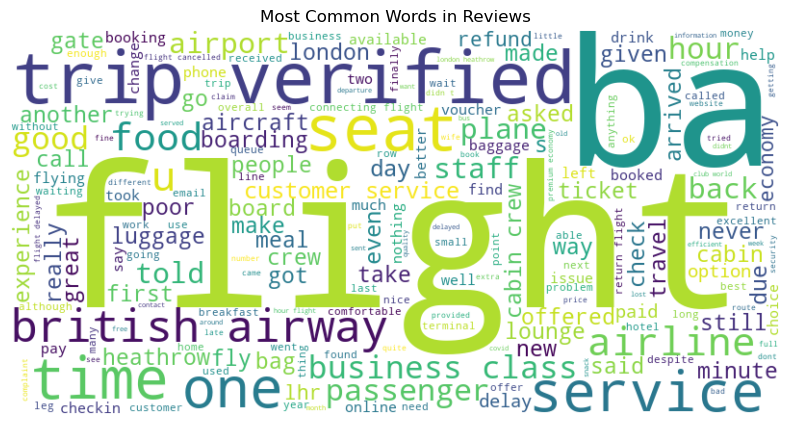

In [33]:
text = ' '.join(df['clean_text'])
wc = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Most Common Words in Reviews")
plt.show()


C:\Users\cmaha\AppData\Local\Temp\ipykernel_9776\1430859230.py:21: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  plt.tight_layout()
C:\Users\cmaha\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


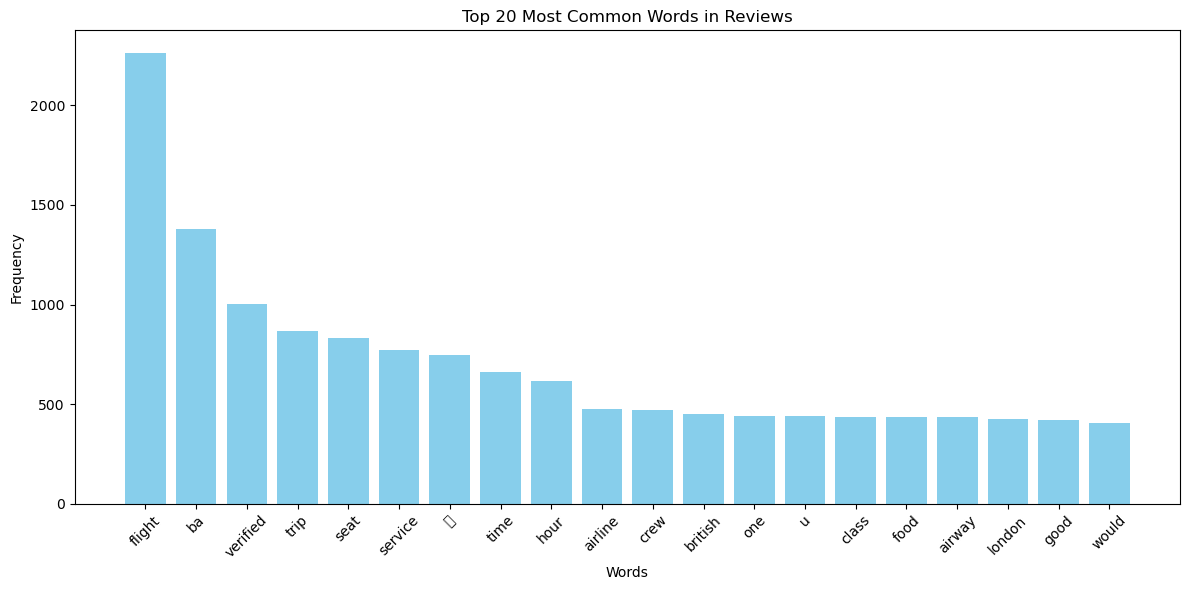

In [37]:
from collections import Counter
import matplotlib.pyplot as plt

# Combine all cleaned text into one string
all_words = ' '.join(df['clean_text']).split()

# Count word frequency
word_freq = Counter(all_words)

# Get top 20 most common words
common_words = word_freq.most_common(20)

# Create bar graph
words, counts = zip(*common_words)
plt.figure(figsize=(12,6))
plt.bar(words, counts, color='skyblue')
plt.title('Top 20 Most Common Words in Reviews')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
